In [1]:
import numpy as np
import math

import struct
import os

from tqdm import tqdm

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import MulticlassConfusionMatrix

from snntorch import surrogate
import snntorch.functional as SF
import torch.nn.functional as F
from torch.nn import NLLLoss, LogSoftmax

from snntorch import spikegen

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import snntorch.spikeplot as splt
import imageio

from sklearn.metrics import ConfusionMatrixDisplay

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
import visualize
import dataset as ds

## Constants

In [3]:
nCublets = 1000
nSensors = 100
max_t = 20
dt = 0.2
timesteps = int(max_t/dt)

In [4]:
labels_map = {
  -1: "unclassified",
   0: "proton",
   1: "kaon",
   2: "pion",
   3: "other"
}
nClasses = len(labels_map)-1

# SNN Definition and Training

In [5]:
class Spiking_Net(nn.Module):
    """FCN with variable neural model and number of layers."""

    def __init__(self, net_desc, spikegen_fn):
        super().__init__()
        
        self.n_neurons = net_desc["layers"]
        self.timesteps = net_desc["timesteps"]
        self.output = net_desc["output"]

        modules = []
        for i_layer in range(1, len(self.n_neurons)):
            modules.append(nn.Linear(in_features=self.n_neurons[i_layer-1], out_features=self.n_neurons[i_layer]))
            if "model" in net_desc:
                modules.append(net_desc["model"](**net_desc["neuron_params"][i_layer]))
            else:
                modules.append(net_desc["neuron_params"][i_layer][0](**(net_desc["neuron_params"][i_layer][1])))
        self.network = nn.Sequential(*modules)

        self.spikegen_fn = spikegen_fn

    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self.spikegen_fn(data)

        # Initalize membrane potential
        mem = []
        for i, module in enumerate(self.network):
            if i%2==1:
                res = module.reset_mem()
                if type(res) is tuple:
                    mem.append(list(res))
                else:
                    mem.append([res])

        # Record the final layer
        spk_rec = []
        mem_rec = []

        # Loop over 
        spk = None
        for step in range(self.timesteps):
            for i_layer in range(len(self.network)//2):
                if i_layer == 0:
                    cur = self.network[2*i_layer](x[step])
                else:
                    cur = self.network[2*i_layer](spk)
                
                spk, *(mem[i_layer]) = self.network[2*i_layer+1](cur, *(mem[i_layer]))

                if i_layer == len(self.network)//2-1:
                    spk_rec.append(spk)
                    mem_rec.append(mem[i_layer][-1])

        if self.output == "spike":
            return torch.stack(spk_rec, dim=0)
        elif self.output == "membrane":
            return torch.stack(mem_rec, dim=0)

In [6]:
class Trainer():

    def __init__(self, net, loss_fn, optimizer,
                 train_dataset, val_dataset, test_dataset, predict=None):
        self.net = net
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.datasets = {"train": train_dataset, "validation": val_dataset, "test": test_dataset}
        self.predict = predict

        self.current_epoch = 0
        self.loss_hist = {"train": {}, "validation": {}, "test": {}}
        self.acc_hist = {"validation": {}, "test": {}}    


    def test(self, dataset_name, transform=None):

        # by default, computes accuracy on test dataset
        try:
            if dataset_name == "validation" or dataset_name == "test":
                dataset = self.datasets[dataset_name]
            else:
                raise NameError("Unidentified dataset name. Please choose between \"validation\" or \"test\".")
        except NameError as n:
            print(f"Error: {n}")

        temp_loss = []
        temp_acc = []

        self.net.eval()
        with torch.no_grad():
            temp_loss = []
            for data, targets in dataset:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)
                pred, _ = self.predict(output, targets)

                # compute loss
                loss = self.loss_fn(pred, targets)
                temp_loss.append(loss.item())

                # calculate total accuracy
                if self.predict is not None:
                    pred, acc = self.predict(output, targets, transform)
                    temp_acc.append(acc)

        self.loss_hist[dataset_name][self.current_epoch] = np.mean(temp_loss, 0)
        if self.predict is not None:
            self.acc_hist[dataset_name][self.current_epoch] = np.mean(temp_acc, 0)


    def train(self, num_epochs, verbosity=1):

        self.net.to(device)

        # Validation
        self.test("validation")
        if verbosity:
            print(f"Epoch {self.current_epoch}:")
            print(f"Validation Loss = {self.loss_hist['validation'][self.current_epoch]}")
            if self.predict is not None:
                print(f"Validation Accuracy = {self.acc_hist['validation'][self.current_epoch]}")
            print("\n-------------------------------\n")

        for epoch in tqdm(range(num_epochs), desc="Epoch"):
            self.net.train()
            # Minibatch training loop
            for data, targets in tqdm(self.datasets["train"], desc="Batches", leave=False):
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)
                pred, _ = self.predict(output, targets)

                # compute loss
                loss_val = self.loss_fn(pred, targets)

                # Gradient calculation + weight update
                self.optimizer.zero_grad()
                loss_val.backward()
                self.optimizer.step()

                # Store loss history for future plotting
                if self.current_epoch in self.loss_hist["train"]:
                    self.loss_hist["train"][self.current_epoch].append(loss_val.item())
                else:
                    self.loss_hist["train"][self.current_epoch] = [loss_val.item()]

            self.current_epoch += 1

            # Validation
            self.test("validation")

            if verbosity:
                print(f"Epoch {self.current_epoch}:")
                print(f"Validation Loss = {self.loss_hist['validation'][self.current_epoch]}")
                if self.predict is not None:
                    print(f"Validation Accuracy = {self.acc_hist['validation'][self.current_epoch]}")
                print("\n-------------------------------\n")

    
    def plot_loss(self, validation=True, logscale=True):

        loss = [l for l_per_epoch in self.loss_hist["train"].values() for l in l_per_epoch]
        fig = plt.figure(facecolor="w", figsize=(10, 6))
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        if logscale:
            plt.yscale("log")
        plt.plot(loss, label="Training")
        if validation:
            x = [i*len(self.datasets["train"]) for i in self.loss_hist["validation"]]
            plt.plot(x, list(self.loss_hist["validation"].values()), color='orange', marker='o', linestyle='dashed', label="Validation")
        
        plt.legend(loc='upper right')
        plt.show()

    
    def ConfusionMatrix(self, *args, **kwargs):

        cm = MulticlassConfusionMatrix(*args, **kwargs)

        self.net.eval()
        with torch.no_grad():
            for data, targets in self.datasets["test"]:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)

                # calculate total accuracy
                pred, acc = self.predict(output, targets)
                cm.update(pred, targets)
        
        return cm
    

    def plot_pred_vs_target(self, nbins, transform=None, logscale=False, *args, **kwargs):

        self.net.eval()
        all_targets = []
        all_predictions = []
        with torch.no_grad():
            for data, targets in self.datasets["test"]:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                output = self.net(data)

                # calculate total accuracy
                pred, acc = self.predict(output, targets, transform)

                if transform:
                    targets = transform(targets)
                all_targets.extend(targets.tolist())
                all_predictions.extend(pred.tolist())

        fig = plt.figure(facecolor="w", figsize=(10, 6))
        plt.xlabel("Targets")
        plt.ylabel("Prediction")
        if logscale:
            plt.hist2d(all_targets, all_predictions, nbins, norm=SymLogNorm(*args, **kwargs), cmap='viridis')
        else:
            plt.hist2d(all_targets, all_predictions, nbins)

        # Add a color bar
        plt.colorbar(label='Counts')
        plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')


# Particle Classification

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data", max_files=5, target="particle")

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
from collections import Counter
Counter([d[1] for d in data_train])

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps)

In [ ]:
def comp_accuracy(output, targets):
    _, predicted = output.sum(dim=0).max(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()

    return predicted, correct/total

In [ ]:
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

train_net = Trainer(net, loss_fn, optimizer, train_load, val_load, test_load, comp_accuracy)

In [ ]:
num_epochs = 5
train_net.train(num_epochs)

In [ ]:
train_net.plot_loss()

In [ ]:
train_net.test("test", mc=True, num_classes=nClasses)
print(train_net.loss_hist["test"])
train_net.cm["test"].plot()

# Energy Regression

In [27]:
dataset = ds.build_dataset("../Data/PrimaryOnly/", max_files=100, primary_only=True, target="energy",
                           transform=lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1])-2, torch.float32)))

mask = [((d[0] != 0).any() and d[1] > 0).item()  and i < 10000  for i, d in enumerate(dataset)]
dataset = dataset[mask]
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

Minimum energy: 0.007638163398951292


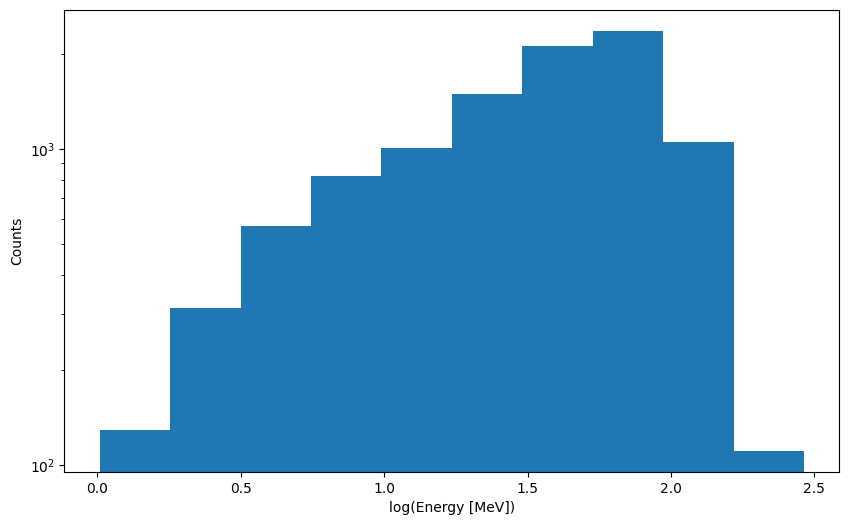

In [28]:
energies = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("log(Energy [MeV])")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(energies)

print(f"Minimum energy: {min(energies)}")

In [ ]:
net_desc_regression = {
    "layers" : [100, 200, 1],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0e20,
                    "learn_threshold": False, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def _spikegen(data):
    spike_data = data.transpose(0,1) 
    spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
    return spike_train


### Membrane Potential

In [ ]:
net_desc_regression_multi = {
    "layers" : [400, 200, 1],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0e20,
                    "learn_threshold": False, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

def predict_from_mem(output, targets, transform=None):
    prediction = output[-1].squeeze(1)
    if transform:
        prediction, targets = transform(prediction), transform(targets)
    accuracy = torch.abs((targets - prediction)/targets)
    return prediction, torch.mean(accuracy)

net = Spiking_Net(net_desc_regression_multi, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net = Trainer(net, loss_fn, optimizer, train_load, val_load, test_load, predict_from_mem)

In [ ]:
num_epochs = 5
train_net.train(num_epochs)

In [ ]:
train_net.test("test")
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_loss()
train_net.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_net.test("test", transform=antitransform)
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

### SpikeFreq

In [29]:
population = 30
net_desc_spikefreq = {
    "layers" : [400, 50, population],
    "timesteps": 100,
    "output": "spike",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.atan(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.atan(),
                    }]
                }
    }

def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

def predict_spikefreq(output, targets, transform=None):
    prediction = output.sum((0,2))/(output.shape[2])
    if transform:
        prediction, targets = transform(prediction), transform(targets)
    accuracy = torch.abs((targets - prediction)/targets)
    return prediction, torch.mean(accuracy)

net = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net = Trainer(net, loss_fn, optimizer, train_dataset, val_dataset, test_dataset, predict_spikefreq)

Epoch 0:
Validation Loss = 2.1254194736480714
Validation Accuracy = 1.4463114738464355

-------------------------------



Epoch:  20%|██        | 1/5 [00:20<01:22, 20.66s/it]

Epoch 1:
Validation Loss = 0.03146762438118458
Validation Accuracy = 0.1630358099937439

-------------------------------



Epoch:  40%|████      | 2/5 [00:39<00:59, 19.85s/it]

Epoch 2:
Validation Loss = 0.017287188799430926
Validation Accuracy = 0.1101667508482933

-------------------------------



Epoch:  60%|██████    | 3/5 [00:58<00:38, 19.48s/it]

Epoch 3:
Validation Loss = 0.015284306354199846
Validation Accuracy = 0.10063233226537704

-------------------------------



Epoch:  80%|████████  | 4/5 [01:18<00:19, 19.52s/it]

Epoch 4:
Validation Loss = 0.01397912836012741
Validation Accuracy = 0.09570303559303284

-------------------------------



Epoch: 100%|██████████| 5/5 [01:37<00:00, 19.60s/it]

Epoch 5:
Validation Loss = 0.013798150389144817
Validation Accuracy = 0.09411099553108215

-------------------------------



Test loss: 0.015226688794791698
Test relative error: 12.966169357299805%


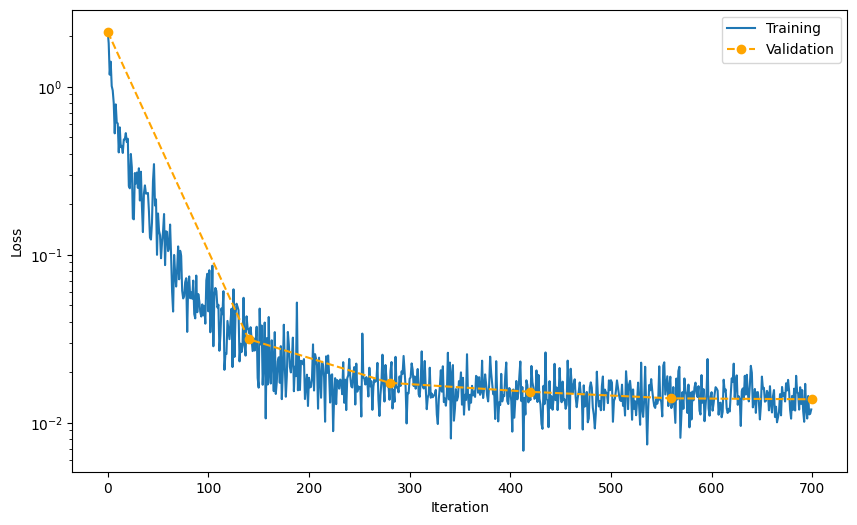

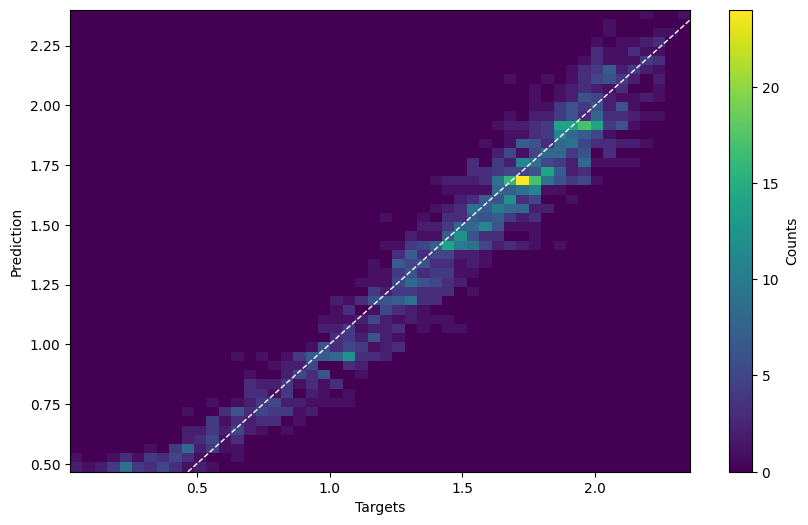

In [30]:
num_epochs=5
train_net.train(num_epochs)

train_net.test("test")
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_loss()
train_net.plot_pred_vs_target(50, logscale=False, linthresh=1)

Test loss: 0.015216972554723422
Test relative error: 21.991147994995117%


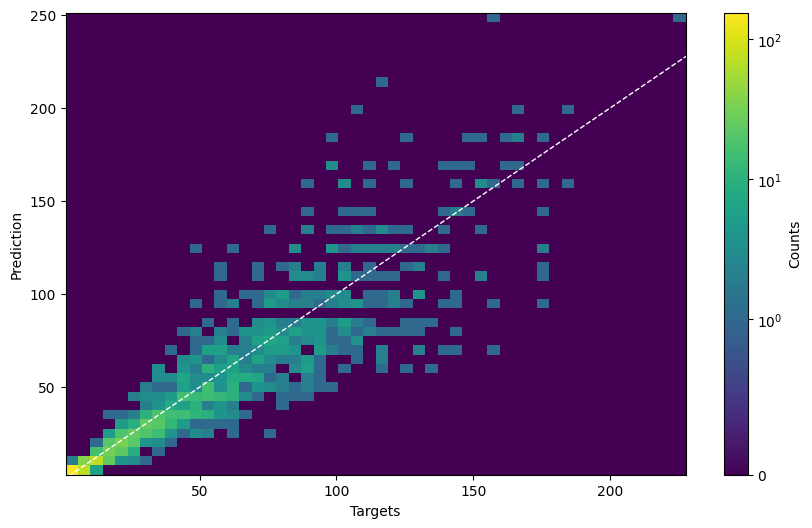

In [31]:
def antitransform(x):
    return torch.pow(10, x)

train_net.test("test", transform=antitransform)
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

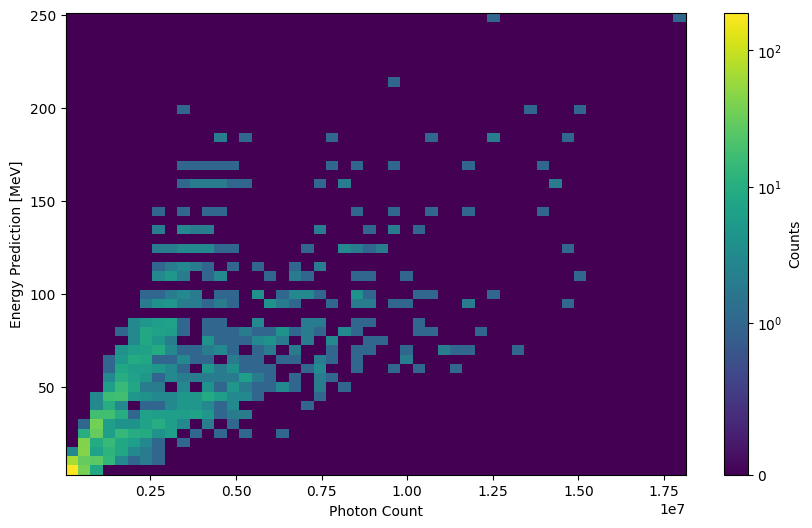

In [32]:
net.eval()
all_x = []
all_predictions = []
with torch.no_grad():
    for data, targets in test_dataset:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        output = net(data)
        # calculate total accuracy
        pred, acc = predict_spikefreq(output, targets, antitransform)
        all_predictions.extend(pred.tolist())
        all_x.extend(data.sum((1,2)).tolist())
        
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Photon Count")
plt.ylabel("Energy Prediction [MeV]")
plt.hist2d(all_x, all_predictions, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
# Add a color bar
plt.colorbar(label='Counts')
plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

### Linear Model

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2", max_files=5, primary_only=True,
                                                   target=["energy", "centroid"])

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/All", max_files=100, primary_only=False,
                                                   target=["energy", "centroid"])

In [ ]:
lin_model     = LinearRegression()
lin_model_log = LinearRegression()

x, y = zip(*[data_train[i] for i in range(len(data_train))])
E = np.array([y[0] for y in y])
centroid = np.array([y[1] for y in y])
#primary = np.array([y[2] for y in y])

# Convert to NumPy arrays
x = torch.stack(x).sum((1,2)).numpy()  # Convert features to NumPy

# eliminate results with no photons
mask = x > 0
x = x[mask]
E = E[mask]
centroid = centroid[mask]
#primary = primary[mask]

# convert to double log scale
x_log = np.log10(x)
E_log = np.log10(E)

lin_model.fit(x.reshape(-1,1), E)
lin_model_log.fit(x_log.reshape(-1,1), E_log)
print("Linear Model:")
print("Slope:", lin_model.coef_[0])
print("Intercept:", lin_model.intercept_)
print("\n###################\n\nLinear Model Trained on logs:")
print("Slope:", lin_model_log.coef_[0])
print("Intercept:", lin_model_log.intercept_)

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("log(Energy [MeV])")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(E_log)

In [ ]:
x_test, y_test = zip(*[data_train[i] for i in range(len(data_test))])
E_test = np.array([y[0] for y in y_test])
centroid_test = np.array([y[1] for y in y_test])
#primary_test = np.array([y[2] for y in y_test])

# Convert to NumPy arrays
x_test = torch.stack(x_test).sum((1,2)).numpy()  # Convert features to NumPy

# eliminate results with no photons
mask = x_test > 0
x_test = x_test[mask]
E_test = E_test[mask]
centroid_test = centroid_test[mask]
#primary_test = primary_test[mask]

x_test_log = np.log10(x_test)
E_test_log = np.log10(E_test)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

x_plot = np.arange(0.1, np.max(x_test), 1e3)
y_plot = lin_model.predict(x_plot.reshape(-1,1))
x_plot_log = np.arange(0.1, np.max(x_test_log), 0.1)
y_plot_log = lin_model_log.predict(x_plot_log.reshape(-1,1))

ax[0].set_xlabel("log(Photon Count)")
ax[0].set_ylabel("log(Energy [MeV])")
hb0 = ax[0].hist2d(x_test_log, E_test_log, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
ax[0].plot(np.log10(x_plot), np.log10(y_plot), color='white',
           linewidth=2, linestyle='--', label="Linear Model Prediction")
ax[0].plot(x_plot_log, y_plot_log, color='#FF00FF',
           linewidth=2, linestyle='--', label="Log Model Prediction")
cbar0 = fig.colorbar(hb0[3], ax=ax[0])
cbar0.set_label('Data')  # Label for the first colorbar
ax[0].legend()

ax[1].set_xlabel("Photon Count")
ax[1].set_ylabel("Energy [MeV]")
hb1 = ax[1].hist2d(x_test, E_test, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
ax[1].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[1].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
cbar1 = fig.colorbar(hb1[3], ax=ax[1])
cbar1.set_label('Data')  # Label for the first colorbar
ax[1].legend()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

condition = centroid_test[:,1] < 5

ax[0].set_title("Y idx < 5")
ax[0].set_ylabel("Energy [MeV]")
hb0 = ax[0].hist2d(x_test[condition], E_test[condition], 50, norm=SymLogNorm(linthresh=1, vmax=1e4, vmin=0), cmap='viridis')
ax[0].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[0].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
ax[0].legend()


condition = centroid_test[:,1] >= 5

ax[1].set_title("Y idx >= 5")
hb1 = ax[1].hist2d(x_test[condition], E_test[condition], 50, norm=SymLogNorm(linthresh=1, vmax=1e4, vmin=0), cmap='viridis')
ax[1].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[1].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
ax[1].legend()

cbar1 = fig.colorbar(hb1[3], ax=ax)
cbar1.set_label('Data') 
fig.text(0.5, 0.04, 'Photon Count', ha='center')
#plt.tight_layout(rect=[0.05, 0.05, 1, 1])

In [ ]:
E_pred = lin_model.predict(x_test.reshape(-1,1))
acc = np.mean(abs((E_test-E_pred)/E_test)*100)
print(f"Mean relative error: {acc}%")

In [ ]:
E_pred_log = lin_model_log.predict(x_test_log.reshape(-1,1))
acc = np.mean(abs((np.pow(10,E_test_log)-np.pow(10,E_pred_log))/np.pow(10,E_test_log))*100)
print(f"Mean relative error: {acc}%")

In [ ]:
mask_up   = E_test_log > lin_model_log.predict(x_test_log.reshape(-1,1))
mask_down = E_test_log < lin_model_log.predict(x_test_log.reshape(-1,1))

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(8,6))
ax.hist(centroid_test[mask_up, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='blue', facecolor='white', linewidth=1.5, label='E > prediction', alpha=0.8)
ax.hist(centroid_test[mask_down, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='orange', facecolor='white', linewidth=1.5, label='E < prediction', alpha=0.8)
ax.hist(centroid_test[:, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='grey', facecolor='lightgrey', alpha=0.2, linewidth=1.5, label='Global')
ax.set_xticks([i for i in range(10)])
ax.legend()
ax.set_xlabel("Centroid Y cell")
ax.set_ylabel("Counts per cell")

# Energy Centroid

## X

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2",  primary_only=True, target="centroid",
                                                   transform=lambda x: (x[0], ds.to_tensor_and_dtype(x[1][0], torch.float32)))
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
X = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("X coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(X)

In [ ]:
population = 100
net_desc_spikefreq = {
    "layers" : [400, 50, population],
    "timesteps": 100,
    "output": "spike",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def predict_spikefreq(output, targets, transform=None):
    prediction = output.sum((0,2))/(output.shape[2])
    if transform:
        prediction, targets = transform(prediction), transform(targets)
    accuracy = torch.abs((targets - prediction))
    return prediction, torch.mean(accuracy)

net_x = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer_x = torch.optim.Adam(net_x.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_x = Trainer(net_x, loss_fn, optimizer_x, train_load, val_load, test_load, predict_spikefreq)

In [ ]:
num_epochs=10
train_net_x.train(num_epochs)

train_net_x.test("test")
print(f"Test loss: {train_net_x.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net_x.acc_hist['test'][num_epochs]*100}%")
train_net_x.plot_loss()
train_net_x.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Z

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2",  primary_only=True, target="centroid",
                                                   transform=lambda x: (x[0], ds.to_tensor_and_dtype(x[1][2], torch.float32)))
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
Z = ((np.array([d[1] for d in data_val])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Z coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Z, bins=[i for i in range(11)])

In [ ]:
net_z = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

optimizer_z = torch.optim.Adam(net_z.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_z = Trainer(net_z, loss_fn, optimizer_z, train_load, val_load, test_load, predict_spikefreq)

In [ ]:
num_epochs=10
train_net_z.train(num_epochs)

train_net_z.test("test")
print(f"Test loss: {train_net_z.loss_hist['test'][10]}")
print(f"Test relative error: {train_net_z.acc_hist['test'][10]*100}%")
train_net_z.plot_loss()
train_net_z.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Y

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2",  primary_only=True, target="centroid",
                                                   transform=lambda x: (x[0], ds.to_tensor_and_dtype(x[1][1], torch.float32)))
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
Y = ((np.array([d[1] for d in data_val])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Y coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Y, bins=[i for i in range(10)])

In [ ]:
net_y = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

optimizer_y = torch.optim.Adam(net_y.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_y = Trainer(net_y, loss_fn, optimizer_y, train_load, val_load, test_load, predict_spikefreq)

In [ ]:
num_epochs=10
train_net_y.train(num_epochs)

train_net_y.test("test")
print(f"Test loss: {train_net_y.loss_hist['test'][10]}")
print(f"Test relative error: {train_net_y.acc_hist['test'][10]*100}%")
train_net_y.plot_loss()
train_net_y.plot_pred_vs_target(50, logscale=False, linthresh=1)

## X, Y and Z together

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2",  primary_only=True, target="centroid",
                                                   transform=lambda x: (x[0], ds.to_tensor_and_dtype(x[1], torch.float32)))
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [ ]:
set_seed(12)
a = torch.rand(size=(100,5,30))
b = torch.rand(size=(5,3))
p, a = predict_spikefreq_multitask(a, b)
print(p.shape, a.shape)
t = torch.rand(size=(5,3))
print(t)
print(p)
loss_fn = nn.MSELoss(reduction='sum')
o = loss_fn(t, p)
print(o)

In [ ]:
population = 10
net_centroid = {
    "layers" : [400, 200, 3*population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def predict_spikefreq_multitask(output, targets, transform=None):
    population=10
    output = output.reshape(output.shape[0], output.shape[1], population, -1)
    prediction = output.sum((0,2))/(output.shape[0]*output.shape[2])
    if transform:
        prediction, targets = transform(prediction), transform(targets)
    accuracy = torch.abs((targets - prediction)/targets)
    return prediction, torch.mean(accuracy, 0)

net_c = Spiking_Net(net_centroid, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer_c = torch.optim.Adam(net_c.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_c = Trainer(net_c, loss_fn, optimizer_c, train_load, val_load, test_load, predict_spikefreq_multitask)

In [ ]:
train_net_c.train(5)

In [ ]:
train_net_c.acc_hist["validation"]

# Energy Dispersion

## Radial

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2", max_files=5, target="sigmaR",
                                                   transform= lambda x: (x[0], ds.to_tensor_and_dtype(x[1], torch.float32)))

batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
sigmaR = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel(r'$\sigma_{R}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaR)

#print(f"Minimum energy: {min(energies)}")

In [ ]:
net_sR = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

optimizer_sR = torch.optim.Adam(net_sR.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_sR = Trainer(net_sR, loss_fn, optimizer_sR, train_load, val_load, test_load, predict_spikefreq)

In [ ]:
num_epochs=10
train_net_sR.train(num_epochs)

train_net_sR.test("test")
print(f"Test loss: {train_net_sR.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net_sR.acc_hist['test'][num_epochs]*100}%")
train_net_sR.plot_loss()
train_net_sR.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Z

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2", max_files=5, target="sigmaZ",
                                                   transform= lambda x: (x[0], ds.to_tensor_and_dtype(x[1], torch.float32)))

batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
sigmaZ = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel(r'$\sigma_{Z}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaZ)

#print(f"Minimum energy: {min(energies)}")

In [ ]:
net_sZ = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

optimizer_sZ = torch.optim.Adam(net_sZ.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_sZ = Trainer(net_sZ, loss_fn, optimizer_sZ, train_load, val_load, test_load, predict_spikefreq)

num_epochs=10
train_net_sZ.train(num_epochs)

train_net_sZ.test("test")
print(f"Test loss: {train_net_sZ.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net_sZ.acc_hist['test'][num_epochs]*100}%")
train_net_sZ.plot_loss()
train_net_sZ.plot_pred_vs_target(50, logscale=False, linthresh=1)

# Energy Regression + Y Position

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2",  primary_only=True, target="energy",
                                                   transform=lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1]), torch.float32)))

batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

def spikegen_with_position(data, *args, **kwargs):
    spk1 = spikegen_multi(data, *args, **kwargs)
    spk2 = net_y(data)

    output = torch.cat((spk1, spk2), dim=2)

    return output


population = 10
net_desc_spikefreq_with_pos = {
    "layers" : [410, 200, population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

net_E = Spiking_Net(net_desc_spikefreq_with_pos, lambda x: spikegen_with_position(x,4))

optimizer_E = torch.optim.Adam(net_E.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_E = Trainer(net_E, loss_fn, optimizer_E, train_load, val_load, test_load, predict_spikefreq)
    

In [ ]:
num_epochs=10
train_net_E.train(num_epochs)

train_net_E.test("test")
print(f"Test loss: {train_net_E.loss_hist['test'][10]}")
print(f"Test relative error: {train_net_E.acc_hist['test'][10]*100}%")
train_net_E.plot_loss()
train_net_E.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_net_E.test("test", transform=antitransform)
print(f"Test loss: {train_net_E.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net_E.acc_hist['test'][num_epochs]*100}%")
train_net_E.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

In [ ]:
net_E.eval()
all_x = []
all_predictions = []
with torch.no_grad():
    for data, targets in test_load:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        output = net_E(data)
        # calculate total accuracy
        pred, acc = predict_spikefreq(output, targets, antitransform)
        all_predictions.extend(pred.tolist())
        all_x.extend(data.sum((1,2)).tolist())
        
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Photon Count")
plt.ylabel("Energy Prediction [MeV]")
plt.hist2d(all_x, all_predictions, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
# Add a color bar
plt.colorbar(label='Counts')
plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

# N of interactions

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly", max_files=5, target="N_int",
                                                   transform= lambda x: (x[0], ds.to_tensor_and_dtype(x[1], torch.float32)))

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
Nint = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel(r'$\sigma_{E}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Nint)


In [ ]:
min(Nint)

In [ ]:
idx = 15
print(Nint[idx])
visualize.plot_views(idx, data_train)

# OLD

In [ ]:
class Net_LIF_1L(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                 learn_beta=learnable, learn_threshold=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0)

In [ ]:
class Net_Reg(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = 1                     # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=1e20,
                                 learn_beta=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return  mem2_rec[-1].squeeze(1)

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_steps = timesteps
net2 = Net_Reg(num_inputs, num_hidden, num_steps)

In [ ]:
def accuracy_set(net, data_loader, loss_fn, comp_mc=False):
    mcm = MulticlassConfusionMatrix(num_classes=nClasses, normalize='none')
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr, pred = comp_accuracy(output, targets)
            total += tot
            correct += corr
            if comp_mc:
                mcm.update(pred, targets)

        mean_loss = np.mean(temp_loss)
        acc = correct/total

        return mean_loss, acc, mcm

In [ ]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, batch_size=100):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    # Validation
    mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

    loss_val_hist.append(mean_loss_val)
    acc_val_hist.append(acc_val)
    print(f"Validation Set Loss: {mean_loss_val}")
    print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
    print("\n--------------------------------------------------\n")

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch+1)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

In [ ]:
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
net.train()

In [ ]:
num_epochs = 5
iter_counter = 0

#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

res = train_net(net, train_load, val_load, num_epochs, loss_fn, optimizer, batch_size=100)

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[0])
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[1])
plt.title("Validation loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
test = accuracy_set(net, test_load, loss_fn, True)
test[2].plot()

In [ ]:

for data, targets in train_load:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            print(spike_in.shape)
            break